In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pystan
import seaborn as sns
import scipy
import warnings
import sys
sys.path.append("..")
import bayesian_anova
warnings.filterwarnings('ignore')

Using gpu device 1: GeForce GTX 980 (CNMeM is disabled, cuDNN 4007)


In [2]:
cols = [#'bayesian_prediction_std_bal_acc',
        #'bayesian_prediction_std_f1_score', 
        #'bayesian_prediction_std_auc',
        'epochs',
        'bayesian_entropy__bal_acc', 
        #'bayesian_entropy_f1_score',
        'bayesian_entropy__auc']

In [3]:
experiments = ['mlp_dropout', 'mlp_deterministic', 'poor_bayesian', 'bayesian']

In [4]:
dfs = []
for exp in experiments:
    df_with = pd.read_csv(exp+'_uncertainty_with_unknown.csv')
    df_with_results = df_with.groupby(['inside_labels', 'unknown_labels']).mean()[cols]
    df_without = pd.read_csv(exp+'_uncertainty_without_unknown.csv')
    df_without_results = df_without.groupby(['inside_labels', 'unknown_labels']).mean()[cols]
    dfs.append([exp, df_with_results, df_without_results])

In [5]:
results_cols = ['inside', 'outside',
                'in_epochs', 'out_epochs',
                'in_entropy_acc', 'out_entropy_acc',
                'in_entropy_auc', 'out_entropy_auc']

dfs_results = []
for exp, df_with, df_without in dfs:
    results = pd.DataFrame(columns=results_cols)
    for (in_key, *in_row), (out_key, *out_row) in zip(df_with.itertuples(), df_without.itertuples()):
        assert in_key == out_key
        results.loc[len(results)] = [
            in_key[0], in_key[1],
            in_row[0], out_row[0],
            in_row[1], out_row[1],
            in_row[2], out_row[2],
        ]
    dfs_results.append([exp, results])

In [6]:
final_results_cols = ['inside', 'outside']
for c in results_cols[2:]:
    for exp, _ in dfs_results:
        final_results_cols.append(exp+'_'+c)

In [7]:
final_results = pd.DataFrame(columns=final_results_cols)
for key_row  in zip(*[df.itertuples() for exp, df in dfs_results]):
    for i in range(1, len(key_row)):
        _, *prev_row = key_row[i-1]
        _, *row = key_row[i]
        assert prev_row[0] == row[0]
        assert prev_row[1] == row[1]
        
    _, *row = key_row[0]
    new_row = [row[0], row[1]]
    
    for c in range(2, len(results_cols)):
        for _, *row in key_row:
            new_row.append(row[c])

    final_results.loc[len(final_results)] = new_row

In [8]:
final_results.columns

Index(['inside', 'outside', 'mlp_dropout_in_epochs',
       'mlp_deterministic_in_epochs', 'poor_bayesian_in_epochs',
       'bayesian_in_epochs', 'mlp_dropout_out_epochs',
       'mlp_deterministic_out_epochs', 'poor_bayesian_out_epochs',
       'bayesian_out_epochs', 'mlp_dropout_in_entropy_acc',
       'mlp_deterministic_in_entropy_acc', 'poor_bayesian_in_entropy_acc',
       'bayesian_in_entropy_acc', 'mlp_dropout_out_entropy_acc',
       'mlp_deterministic_out_entropy_acc', 'poor_bayesian_out_entropy_acc',
       'bayesian_out_entropy_acc', 'mlp_dropout_in_entropy_auc',
       'mlp_deterministic_in_entropy_auc', 'poor_bayesian_in_entropy_auc',
       'bayesian_in_entropy_auc', 'mlp_dropout_out_entropy_auc',
       'mlp_deterministic_out_entropy_auc', 'poor_bayesian_out_entropy_auc',
       'bayesian_out_entropy_auc'],
      dtype='object')

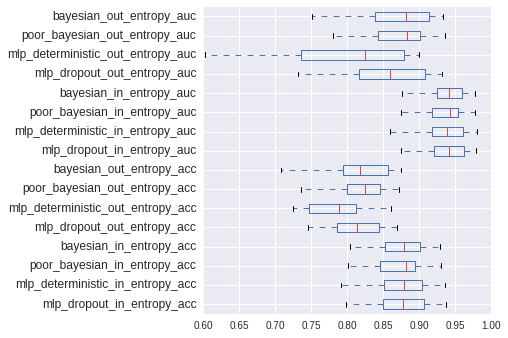

In [9]:
plt.figure()
plt.rcParams['figure.figsize'] = (10, 10)
final_results.boxplot(return_type='axes', vert=False, column=list(final_results.columns)[10:])
plt.subplots_adjust(left=0.4)

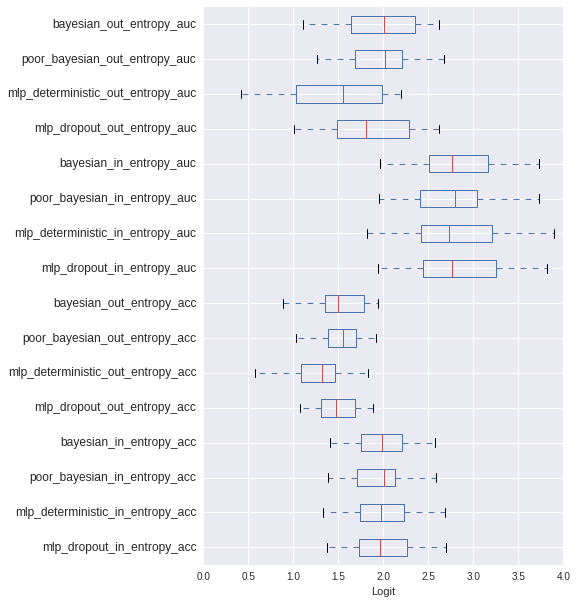

In [10]:
plt.figure()
plt.rcParams['figure.figsize'] = (10, 10)
final_results[list(final_results.columns)[10:]].apply(scipy.special.logit).boxplot(return_type='axes', vert=False)
plt.xlabel("Logit")
plt.subplots_adjust(left=0.4)

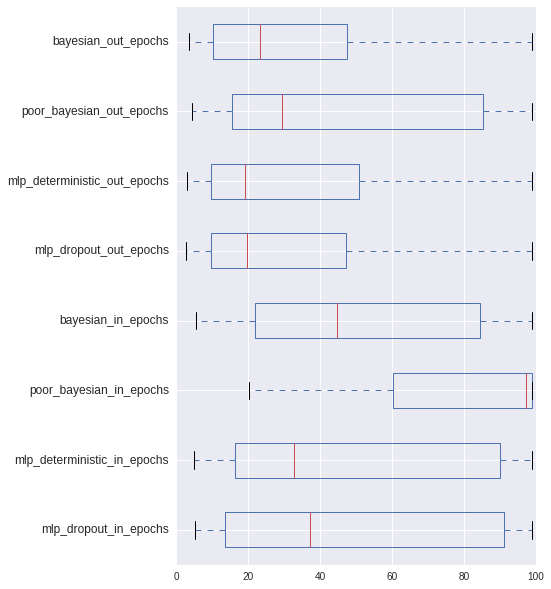

In [11]:
plt.figure()
plt.rcParams['figure.figsize'] = (10, 5)
final_results.boxplot(return_type='axes', vert=False, column=list(final_results.columns)[2:10])
plt.subplots_adjust(left=0.4)

In [12]:
model = pystan.StanModel(model_code=bayesian_anova.one_way_code)

In [13]:
out_acc = ['mlp_deterministic_out_entropy_auc', 'mlp_dropout_out_entropy_auc', 'poor_bayesian_out_entropy_auc', 'bayesian_out_entropy_auc']
y_out = final_results[out_acc].values
y_out = scipy.special.logit(y_out)

in_acc = ['mlp_deterministic_in_entropy_auc', 'mlp_dropout_in_entropy_auc', 'poor_bayesian_in_entropy_auc', 'bayesian_in_entropy_auc']
y_in = final_results[in_acc].values
y_in = scipy.special.logit(y_in)

Inference for Stan model: anon_model_1967665b99160b0ba8694ab613d646dd.
4 chains, each with iter=10000; warmup=5000; thin=5; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu                  2.8  9.5e-4   0.06   2.68   2.76    2.8   2.84   2.91   4000    1.0
theta_free[0]    2.2e-3  9.2e-4   0.06  -0.12  -0.03 1.0e-3   0.03   0.14   4000    1.0
theta_free[1]   -1.3e-3  9.1e-4   0.06  -0.13  -0.03-4.3e-4   0.02   0.12   4000    1.0
theta_free[2]   -1.4e-3  9.2e-4   0.06  -0.14  -0.03-5.6e-4   0.02   0.12   4000    1.0
sigma_likelihood   0.54  7.1e-4   0.04   0.46   0.51   0.54   0.57   0.64   4000    1.0
sigma_theta         0.1  4.0e-3   0.26 7.8e-3   0.03   0.06   0.11   0.43   4000    1.0
theta[0]         2.2e-3  9.2e-4   0.06  -0.12  -0.03 1.0e-3   0.03   0.14   4000    1.0
theta[1]        -1.3e-3  9.1e-4   0.06  -0.13  -0.03-4.3e-4   0.02   0.12   4000    1.0
theta[2]        -1

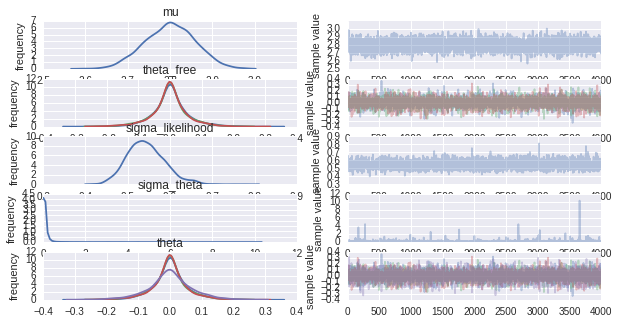

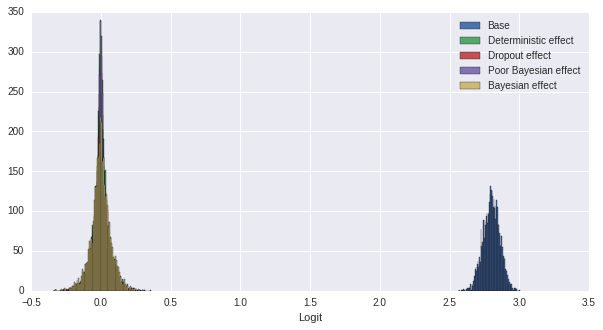

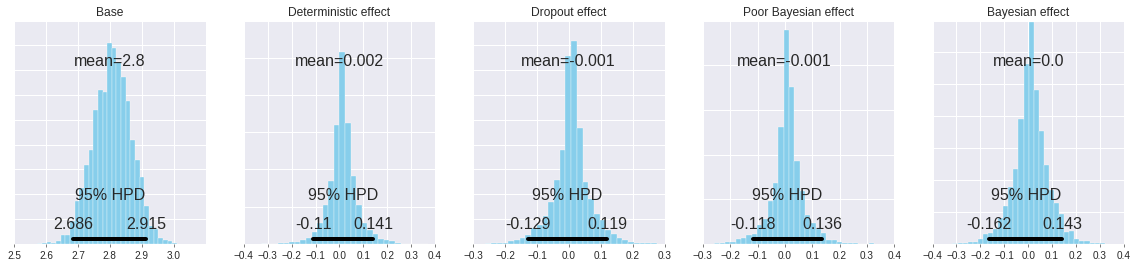

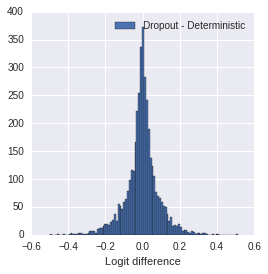

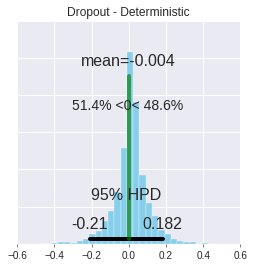

Dropout - Deterministic 95.0 CI: -0.205564407076 0.18915246011 Pr > 0: 0.4855


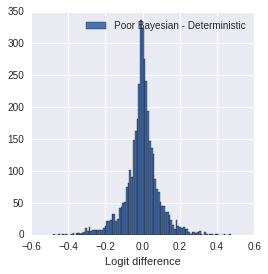

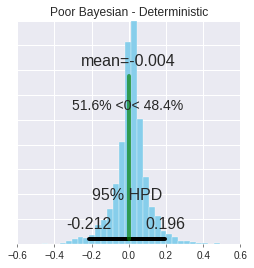

Poor Bayesian - Deterministic 95.0 CI: -0.21474731832 0.193013591939 Pr > 0: 0.484


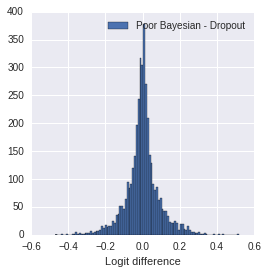

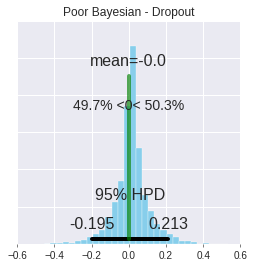

Poor Bayesian - Dropout 95.0 CI: -0.20260421056 0.208495400013 Pr > 0: 0.50325


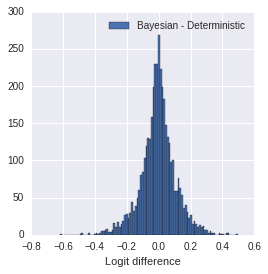

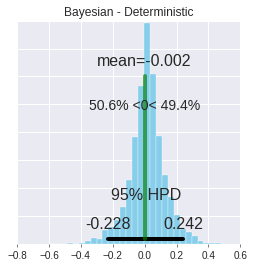

Bayesian - Deterministic 95.0 CI: -0.248067424211 0.228205840704 Pr > 0: 0.4945


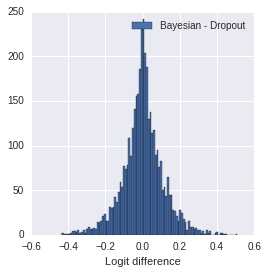

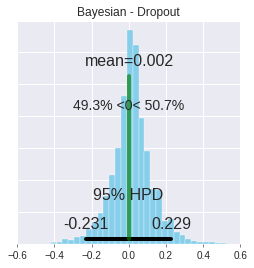

Bayesian - Dropout 95.0 CI: -0.230501177648 0.228961640537 Pr > 0: 0.50725


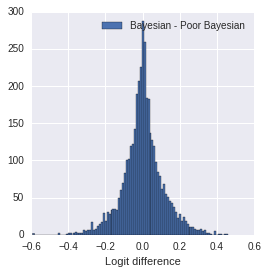

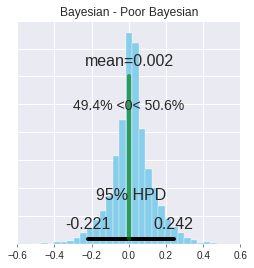

Bayesian - Poor Bayesian 95.0 CI: -0.230467656593 0.235807822266 Pr > 0: 0.506
Inference for Stan model: anon_model_1967665b99160b0ba8694ab613d646dd.
4 chains, each with iter=10000; warmup=5000; thin=5; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu                 1.81  8.4e-4   0.05   1.71   1.78   1.81   1.85   1.92   4000    1.0
theta_free[0]      -0.3  1.6e-3    0.1  -0.49  -0.36   -0.3  -0.23  -0.09   4000    1.0
theta_free[1]    1.7e-3  1.3e-3   0.08  -0.16  -0.06 2.0e-3   0.06   0.17   4000    1.0
theta_free[2]      0.12  1.4e-3   0.09  -0.05   0.06   0.12   0.18   0.31   4000    1.0
sigma_likelihood   0.48  6.4e-4   0.04   0.41   0.45   0.48    0.5   0.56   4000    1.0
sigma_theta        0.42  8.1e-3   0.52   0.08   0.19   0.28   0.47   1.55   4000    1.0
theta[0]           -0.3  1.6e-3    0.1  -0.49  -0.36   -0.3  -0.23  -0.09   4000    1.0
theta[1]         1.7e-3  1.

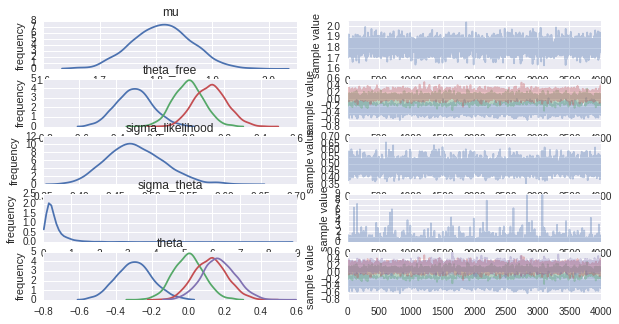

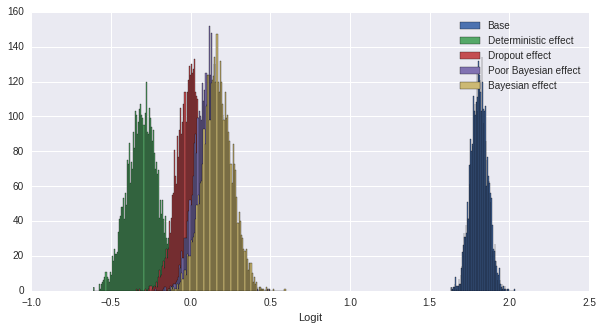

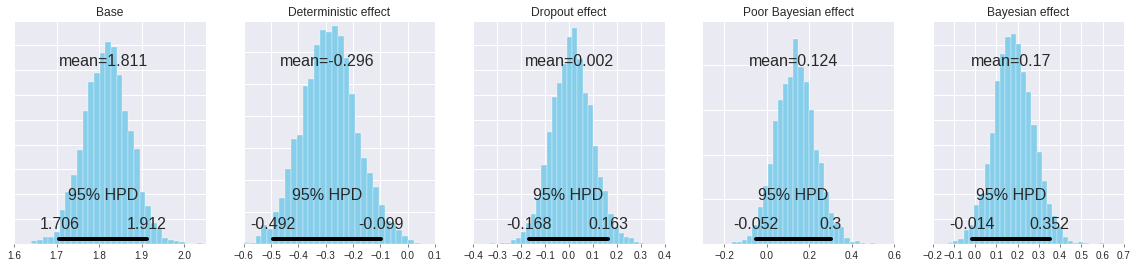

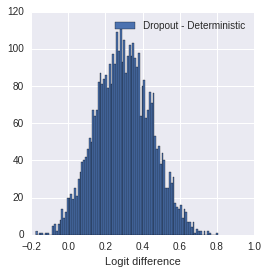

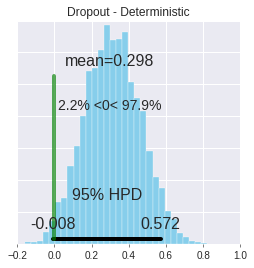

Dropout - Deterministic 95.0 CI: 0.00816056070925 0.593859134384 Pr > 0: 0.9785


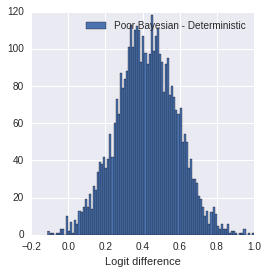

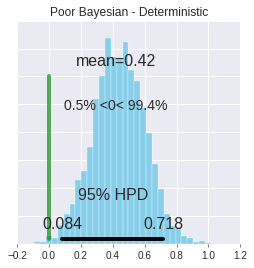

Poor Bayesian - Deterministic 95.0 CI: 0.0975505420552 0.73452106001 Pr > 0: 0.9945


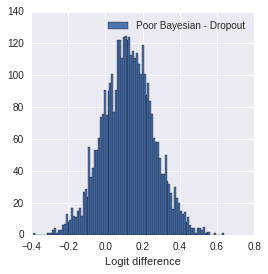

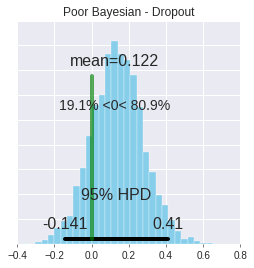

Poor Bayesian - Dropout 95.0 CI: -0.153046994558 0.399076598861 Pr > 0: 0.80925


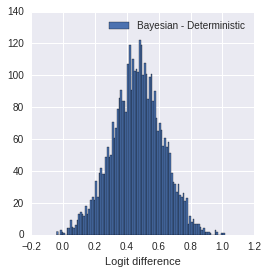

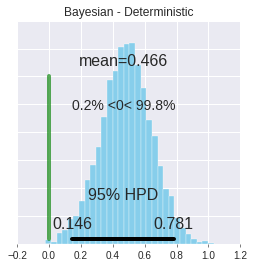

Bayesian - Deterministic 95.0 CI: 0.138599811281 0.77683065907 Pr > 0: 0.99825


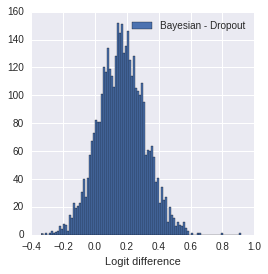

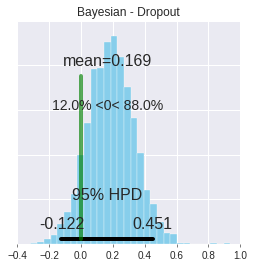

Bayesian - Dropout 95.0 CI: -0.117661096812 0.457944666501 Pr > 0: 0.8805


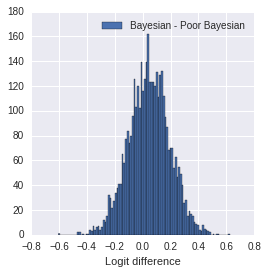

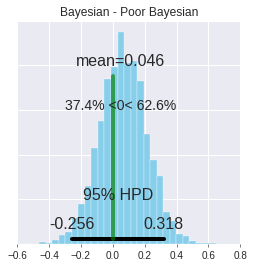

Bayesian - Poor Bayesian 95.0 CI: -0.244323688756 0.337204926778 Pr > 0: 0.626


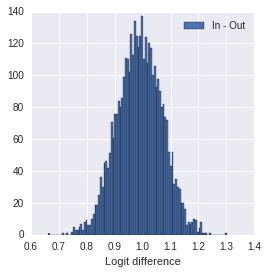

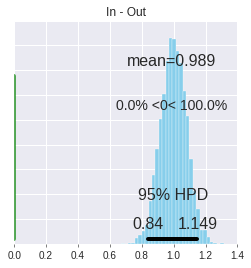

In - Out 95.0 CI: 0.833651172233 1.14396125426 Pr > 0: 1.0


In [14]:
for y in [y_in, y_out]:
    (N, K) = y.shape

    data = {'K': K, 'N': N, 'y': y}
    fit = model.sampling(data=data, iter=10000, chains=4, thin=5)
    
    bayesian_anova.show_results(fit)
    
    trace = fit.extract()
    deterministic = trace['theta'][:,0]
    dropout = trace['theta'][:,1]
    poor_bayesian = trace['theta'][:,2]
    bayesian = trace['theta'][:,3]
    base_mean = trace['mu']
    
    if y is y_in:
        in_mean = np.copy(base_mean)
    else:
        out_mean = np.copy(base_mean)

    bayesian_anova.plot_traces([base_mean, deterministic, dropout, poor_bayesian, bayesian],
                               ["Base", "Deterministic effect", "Dropout effect", "Poor Bayesian effect", "Bayesian effect"])

    bayesian_anova.effect_difference(dropout, deterministic, 'Dropout', 'Deterministic')
    bayesian_anova.effect_difference(poor_bayesian, deterministic, 'Poor Bayesian', 'Deterministic')
    bayesian_anova.effect_difference(poor_bayesian, dropout, 'Poor Bayesian', 'Dropout')
    bayesian_anova.effect_difference(bayesian, deterministic, 'Bayesian', 'Deterministic')
    bayesian_anova.effect_difference(bayesian, dropout, 'Bayesian', 'Dropout')
    bayesian_anova.effect_difference(bayesian, poor_bayesian, 'Bayesian', 'Poor Bayesian')
    
bayesian_anova.effect_difference(in_mean, out_mean, 'In', 'Out')

In [15]:
model_two_way = pystan.StanModel(model_code=bayesian_anova.two_way_code)

Inference for Stan model: anon_model_8ab7764af0212b6538e6ac6793ece96b.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu_in              2.79  1.3e-3   0.06   2.68   2.75   2.79   2.83   2.92   2000   1.02
mu_out              1.8  1.3e-3   0.06    1.7   1.76    1.8   1.84   1.92   2000   1.02
theta_free[0]      -0.1  1.7e-3   0.08  -0.26  -0.16  -0.09  -0.03 6.4e-3   2000   1.06
theta_free[1]   -2.3e-3  1.2e-3   0.05  -0.12  -0.03-2.2e-3   0.03   0.11   2000    1.0
theta_free[2]      0.03  1.3e-3   0.06  -0.06  -0.01   0.02   0.07   0.17   2000   1.03
sigma_likelihood   0.52  6.3e-4   0.03   0.47    0.5   0.52   0.53   0.58   2000    1.0
sigma_theta        0.15  4.0e-3   0.18 8.1e-3   0.05    0.1   0.18   0.65   2000   1.03
theta[0]           -0.1  1.7e-3   0.08  -0.26  -0.16  -0.09  -0.03 6.4e-3   2000   1.06
theta[1]        -2.3e

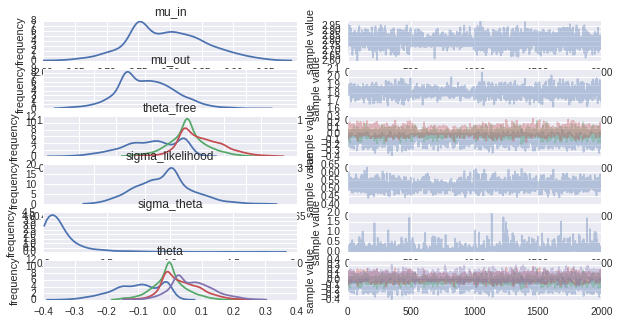

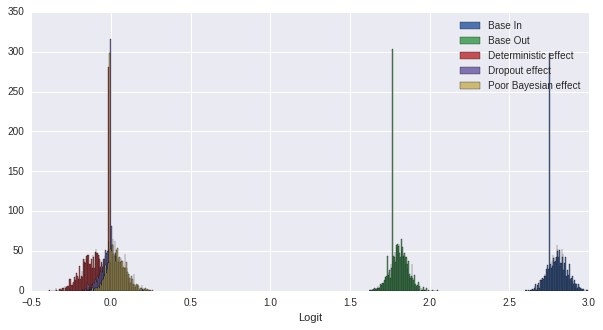

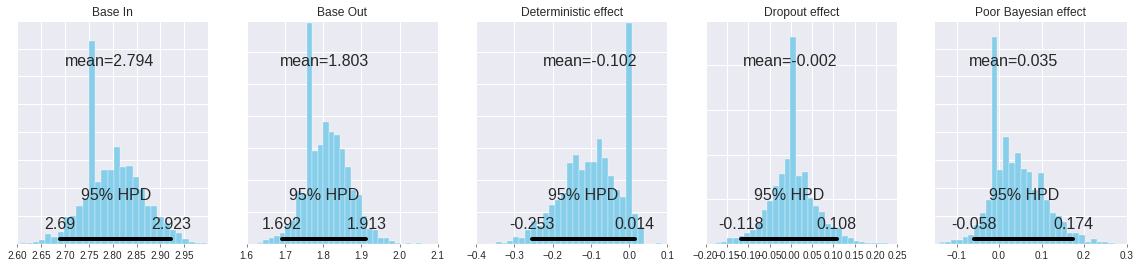

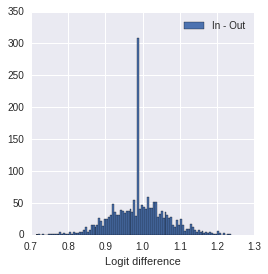

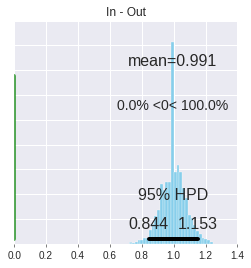

In - Out 95.0 CI: 0.839102382764 1.1494848312 Pr > 0: 1.0


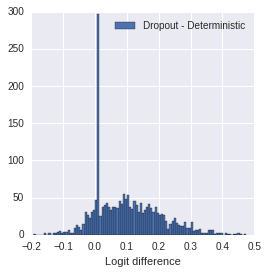

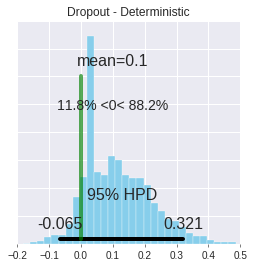

Dropout - Deterministic 95.0 CI: -0.0591930915973 0.329997496438 Pr > 0: 0.8825


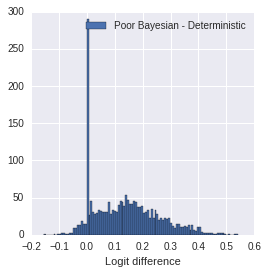

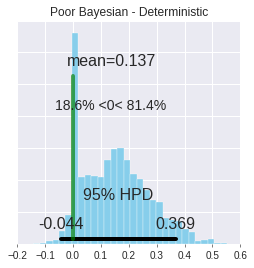

Poor Bayesian - Deterministic 95.0 CI: -0.0272077363106 0.396026616027 Pr > 0: 0.8145


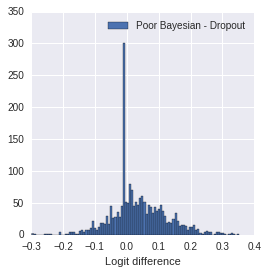

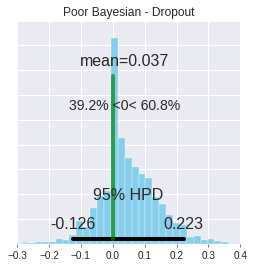

Poor Bayesian - Dropout 95.0 CI: -0.124144680084 0.225038553362 Pr > 0: 0.608


In [16]:
data = {'K': K, 'N': N, 'y_in': y_in, 'y_out': y_out}
fit = model_two_way.sampling(data=data, iter=1000, chains=4)

bayesian_anova.show_results(fit)

trace = fit.extract()
deterministic = trace['theta'][:,0]
dropout = trace['theta'][:,1]
poor_bayesian = trace['theta'][:,2]

bayesian_anova.plot_traces([trace['mu_in'], trace['mu_out'], deterministic, dropout, poor_bayesian],
                               ["Base In", "Base Out", "Deterministic effect", "Dropout effect", "Poor Bayesian effect"])

bayesian_anova.effect_difference(trace['mu_in'], trace['mu_out'], 'In', 'Out')
bayesian_anova.effect_difference(dropout, deterministic, 'Dropout', 'Deterministic')
bayesian_anova.effect_difference(poor_bayesian, deterministic, 'Poor Bayesian', 'Deterministic')
bayesian_anova.effect_difference(poor_bayesian, dropout, 'Poor Bayesian', 'Dropout')